In [16]:
import os
import itertools
from time import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [17]:
category = os.listdir("101_ObjectCategories/")

In [18]:
print category

['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'chair', 'flamingo', 'mandolin', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [4]:
# Counting items(number of images) in each category
item_count = []
for name in category:
    path = "./101_ObjectCategories/" + name
    temp = os.listdir(path)
    item_count.append(len(temp))

In [19]:
# lists for training, validation data and labels for both training and validation images
train_list = []
validation_list = [] 
label_train = []
label_valid = []

# variable to iterate through item_count list
i = 0 
for name in category:
    # variable(int) to store the count of 90% of total images in a specific category
    # PERCENTAGE OF TRAIN AND VALIDATION COUNTS CAN BE CHANGED IN ORDER TO IMPROVE RESULTS
    count1 = int(0.7 * item_count[i])
    
    i += 1
    
    path = "./101_ObjectCategories/" + name
    temp = os.listdir(path)
    
    # variable to iterate through count(int) images
    j = 0
    for item in temp:
        # PATHS to images are stored in train_list so that we can directly access them for manipulation
        st = path + "/" + item
        # IF j is less than count append in TRAIN_LIST, ELSE append in VALIDATION_LIST
        if j <= count1:
            train_list.append(st)
            # Creating label vector by appending category of specific image CORRESPONDING TO EACH IMAGE IN 
            # TRAINING MATRIX
            label_train.append(name)
        else:
            validation_list.append(st)
            label_valid.append(name)
        j += 1
    

In [20]:
print len(train_list), len(validation_list)
print len(label_train), len(label_valid)

6127 2550
6127 2550


In [21]:
# building matrix for training data 

count = 0
train_matrix = []
for train_item in train_list:

    if count == 100:
        break
    count += 1
    
    # Read image as RGB pixel matrix
    image_mat_train = io.imread(train_item, as_grey=True)
    
    # Resizing image
    image_mat_train = resize(image_mat_train, (300, 167))

    # Flatten image
    image_vector_train = []
    for i in range(0, len(image_mat_train)):
        for j in range(0, len(image_mat_train[0])):
            image_vector_train.append(image_mat_train[i][j])
            
    train_matrix.append(image_vector_train)

In [22]:
# building matrix for validation data

count = 0
validation_matrix = []
for valid_item in validation_list:

    # Extra code to limit the execution of for loop
    if count == 100:
        break
    count += 1
    
    # Read image as RGB pixel matrix
    image_mat_valid = io.imread(valid_item, as_grey=True)
    
    # Resizing image [Chances to increase accuracy]
    image_mat_valid = resize(image_mat_valid, (300, 167))

    # Flatten image
    image_vector_valid = []
    for i in range(0, len(image_mat_valid)):
        for j in range(0, len(image_mat_valid[0])):
            image_vector_valid.append(image_mat_valid[i][j])
            
    validation_matrix.append(image_vector_valid)

In [23]:
# Applying PCA for dimensionality reduction

# Keeping track of time taken by PCA algorithm
t0 = time()
pca = PCA(n_components=50, whiten=True).fit(train_matrix)
print "Time taken by PCA %0.3fs::" % (time() - t0)
pca.explained_variance_ratio_

Time taken by PCA 2.892s::


array([ 0.3974073 ,  0.06896098,  0.04761306,  0.04425527,  0.03311075,
        0.02351506,  0.02126864,  0.01856904,  0.01749402,  0.01478866,
        0.01440678,  0.0121041 ,  0.01103192,  0.01048152,  0.00996772,
        0.00933709,  0.0089417 ,  0.0080003 ,  0.00761883,  0.0073954 ,
        0.00724158,  0.00658816,  0.00636027,  0.00612277,  0.00585548,
        0.00558012,  0.00546371,  0.00513582,  0.00499839,  0.00475191,
        0.00459165,  0.00448564,  0.0044097 ,  0.0042454 ,  0.00415673,
        0.00398294,  0.00393161,  0.00377873,  0.00375056,  0.003638  ,
        0.00351008,  0.00340722,  0.00336654,  0.00333748,  0.00321639,
        0.00313896,  0.0030827 ,  0.00300079,  0.00295114,  0.00290321])

In [24]:
# projecting the input data on the eigenfaces orthonormal basis
t0 = time()
X_train_pca = pca.transform(train_matrix)
X_test_pca = pca.transform(validation_matrix)
print "Time taken %0.3fs" % (time() - t0)

Time taken 2.431s


### Code above this point will execute only once
### Below code will run against each query to make prediction

In [25]:
"""
using kNN algorithm to find (k) nearest neighbours on complete dataset(training matrix), value of k(n_neighbours) 
"""

def kNN(k, image_transform):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_train_pca)
    
    distances, indices = neigh.kneighbors(image_transform)
    return indices[0]

# checking if the neighbours have similar labels. If yes then we can return this common label wihthout training SVM
def check_similarity(indices):
    flag = 0
    for i in range(0, len(indices)):
        for j in range(0, len(indices)):
            if label_train[i] != label_train[j]:
                flag = 1
                break
        if flag == 1:
            break
    # if labels are similar return or print the result, else train the SVM on neighbors matrix
    if flag == 0:
        return 0
    else:
        return 1


# Training SVM classifier only on k nearest neighbors
# GridSearchCV search over all the possible combinations of parameters of SVM classifier and choose the best one
def SVM(near_train, near_label, image_transform):
    t0 = time()
    # Here 'C' and 'gamma' are parameters provided as argument to SVM classifier
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    classifier = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)

    classifier = classifier.fit(near_train, near_label)
    print "Time taken for training SVM classifier %0.3fs\n" % (time() - t0)

    # Display the optimal value of parameters found by grid search
    print "Best Estimator found by grid search ::"
    print classifier.best_estimator_
    
    # Predicting using trained classifier
    return classifier.predict(image_transform)

In [26]:
# Driver function for calling transforming image and calling kNN-SVM classifiers

def make_prediction(pos, k):
    # Convert the vector into a numpy array and fit it using pca  
    flat_image_array = np.array(validation_matrix[pos]).reshape(1,-1)
    image_transform = pca.transform(flat_image_array)
    
    indices = kNN(k, image_transform)
    flag = check_similarity(indices)
    if flag == 0:
        # predicted image
        prediction = label_train[indices[0]]
        print "\n(Prediction made by kNN classifier only)"
    else:
        # constructing new train_matrix and label_matix of neighbours
        near_train = []
        near_label = []
        for index in indices:
            near_train.append(X_train_pca[index])
            near_label.append(label_train[index])
        # calling SVM on limited number of training examples(neighbors)
        prediction = SVM(near_train, near_label, image_transform)
        prediction = prediction[0] # label returned as a list, extracting string label from list
        print "\n(Prediction made using both kNN and SVM)"
    
    # displaying output
    print "Predicted label of image:"
    print prediction
    print "\nOriginal label of image:"
    print label_valid[pos]
    
    print "\n\n"
    print "Chosen image is displayed below:"
    io.imshow(io.imread(validation_list[pos], as_grey=True))

Time taken for training SVM classifier 1.137s

Best Estimator found by grid search ::
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

(Prediction made using both kNN and SVM)
Predicted label of image:
airplanes

Original label of image:
airplanes



Chosen image is displayed below:


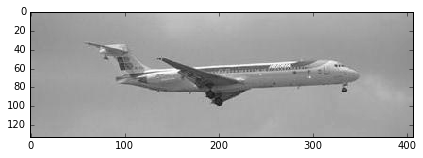

In [28]:
"""
Driver function(make_prediction) call.
(pos) denotes the position of an image in validation set not yet seen by the classifier.
(k) deonotes the nearest neighbors to consider
Output of the function will be be:
    1. The predicted label
    2. Origanl label of image
    3. Image itself
"""

make_prediction(pos=50, k=100)